## 1.  The power of data science

  <p><em>With great power comes great responsibility</em></p>
</blockquote>
<p>This, of course, is an oft-quoted Spider-man line. I don't think any individual need bear the responsibility of a superhero, but it is important to understand the value of technical analysis skills in the context of modern social issues. Within the workplace, data science skills can greatly increase your utility as an employee or prospective applicant. What is not always  mentioned is that these same skills can be applied to positively impact your community. The concept of <strong>open science</strong> has led to new standards in <strong>open data</strong>, and there is an exciting plethora of raw information ready to be probed for insights. Organizations focused on <em>data science for social good</em> are rapidly growing, and the volunteer soup  kitchen seems to have a 21st-century rendition.</p>
<p>Many local and federal governments support access to interesting datasets; as this trend grows, the utility of open information becomes more robust. Data is begging for audacious volunteers to poke and prod it, and make use of the raw input in an impactful way. We can now fight crime as a vigilante - all from behind a computer. </p>
<p>In this notebook, we will explore San Francisco crime data in order to understand the relationship between civilian-reported incidents of crime and police-reported incidents of crime. Along the way we will use table intersection methods to subset our data, aggregation methods to calculate important statistics, and simple visualizations to understand crime trends. </p>

In [147]:
# Load required packages
library(tidyverse)
library(lubridate)

# Read in incidents dataset
incidents <- read_csv("datasets/downsample_police-department-incidents.csv")

# Read in calls dataset
calls <- read_csv("datasets/downsample_police-department-calls-for-service.csv")



Parsed with column specification:
cols(
  IncidntNum = col_double(),
  Category = col_character(),
  Descript = col_character(),
  DayOfWeek = col_character(),
  Date = col_datetime(format = ""),
  Time = col_time(format = ""),
  PdDistrict = col_character(),
  Resolution = col_character(),
  Address = col_character(),
  X = col_double(),
  Y = col_double(),
  Location = col_character(),
  PdId = col_double()
)
Parsed with column specification:
cols(
  `Crime Id` = col_double(),
  Descript = col_character(),
  `Report Date` = col_datetime(format = ""),
  Date = col_datetime(format = ""),
  `Offense Date` = col_datetime(format = ""),
  `Call Time` = col_time(format = ""),
  `Call Date Time` = col_datetime(format = ""),
  Disposition = col_character(),
  Address = col_character(),
  City = col_character(),
  State = col_character(),
  `Agency Id` = col_double(),
  `Address Type` = col_character(),
  `Common Location` = col_character()
)


## 2. First poke and prod
<p>First things first: we need to wrap our heads around the data in order to understand <em>what</em> we have. Let’s <code>glimpse()</code> the data to see if there are any variables in the two datasets that are the same or similar. Then we can ask an investigative question about these variables, and return a simple statistic such as a frequency count.</p>

In [149]:
# Glimpse the structure of both datasets
glimpse(incidents)
glimpse(calls)

# Aggregate the number of reported incidents by Date
daily_incidents <- incidents %>%
    count(Date, sort = TRUE) %>%
    rename(n_incidents = n)

# Aggregate the number of calls for police service by Date
daily_calls <- calls %>%
    count(Date, sort = TRUE) %>%
    rename(n_calls = n)

Rows: 84,000
Columns: 13
$ IncidntNum <dbl> 176122807, 160569314, 160362475, 160435298, 90543656, 18...
$ Category   <chr> "LARCENY/THEFT", "ASSAULT", "ROBBERY", "KIDNAPPING", "MI...
$ Descript   <chr> "GRAND THEFT FROM UNLOCKED AUTO", "BATTERY", "ROBBERY, B...
$ DayOfWeek  <chr> "Saturday", "Thursday", "Tuesday", "Friday", "Tuesday", ...
$ Date       <dttm> 2017-05-13, 2016-07-14, 2016-05-03, 2016-05-27, 2009-05...
$ Time       <time> 10:20:00, 16:00:00, 14:19:00, 23:57:00, 07:40:00, 18:00...
$ PdDistrict <chr> "SOUTHERN", "MISSION", "NORTHERN", "SOUTHERN", "TARAVAL"...
$ Resolution <chr> "NONE", "NONE", "ARREST, BOOKED", "ARREST, BOOKED", "LOC...
$ Address    <chr> "800 Block of BRYANT ST", "MISSION ST / CESAR CHAVEZ ST"...
$ X          <dbl> -122.4034, -122.4182, -122.4299, -122.4050, -122.4612, -...
$ Y          <dbl> 37.77542, 37.74817, 37.77744, 37.78512, 37.71912, 37.806...
$ Location   <chr> "{'latitude': '37.775420706711', 'human_address': '{\"ad...
$ PdId       <dbl> 1.761228

## 3. Mutating join
<p>Now that we have a better understanding of what variables are present in our information set we can see there are shared variables that will allow us to ask a wider variety of questions. We can inquire about the relationship between civilian-reported incidents and police-reported incidents by the date on which the incidents were documented. To combine this information we will perform a type of mutating join between the data frames. The new dataset structure preserves only days on which both civilians reported incidents and police encountered incidents.</p>

In [151]:
# Join data frames to create a new "mutated" set of information
shared_dates <- daily_incidents %>% inner_join(daily_calls, by = "Date")

# Take a glimpse of this new data frame
head(shared_dates)

Date,n_incidents,n_calls
2017-03-01,124,133
2017-09-01,124,138
2016-04-01,120,124
2017-03-17,118,129
2016-11-25,117,115
2017-06-25,114,120


## 4. Inspect frequency trends
<p>We now have a data frame that contains new information generated by combining datasets. In order to understand this new information we must visualize it. And I don't mean just giving the data a <code>glimpse()</code> - a table of raw information limits our comprehension of crime patterns. A picture is worth a thousand words, right? So let's try to represent the information in a concise way that will lead to other questions. We will look at the frequency of calls and incidents across time to help discern if there is a relationship between these variables.</p>
<p>Often times restructuring of data is required to perform new operations like plotting. <code>ggplot2</code> is amenable to "long format" data rather than "wide format" data. To plot time series data in <code>ggplot2</code> we would like one column to represent the dates, one column to represent the counts, and one column to map each observation to either <code>n_calls</code> or <code>n_incidents</code>. This allows us to pass a single column to each <code>x</code>, <code>y</code>, and <code>color</code> argument in <code>ggplot()</code>. We want the <code>key</code> column in <code>gather()</code> to define the columns <code>n_incidents</code> and <code>n_calls</code>. The <code>value</code> column will define each of these variable's corresponding counts. By leaving the <code>Date</code> column out of <code>key</code>, the result is a long and narrow data frame with multiple rows for each  date observation.</p>

Date,report,count
2017-03-01,n_incidents,124
2017-09-01,n_incidents,124
2016-04-01,n_incidents,120
2017-03-17,n_incidents,118
2016-11-25,n_incidents,117
2017-06-25,n_incidents,114


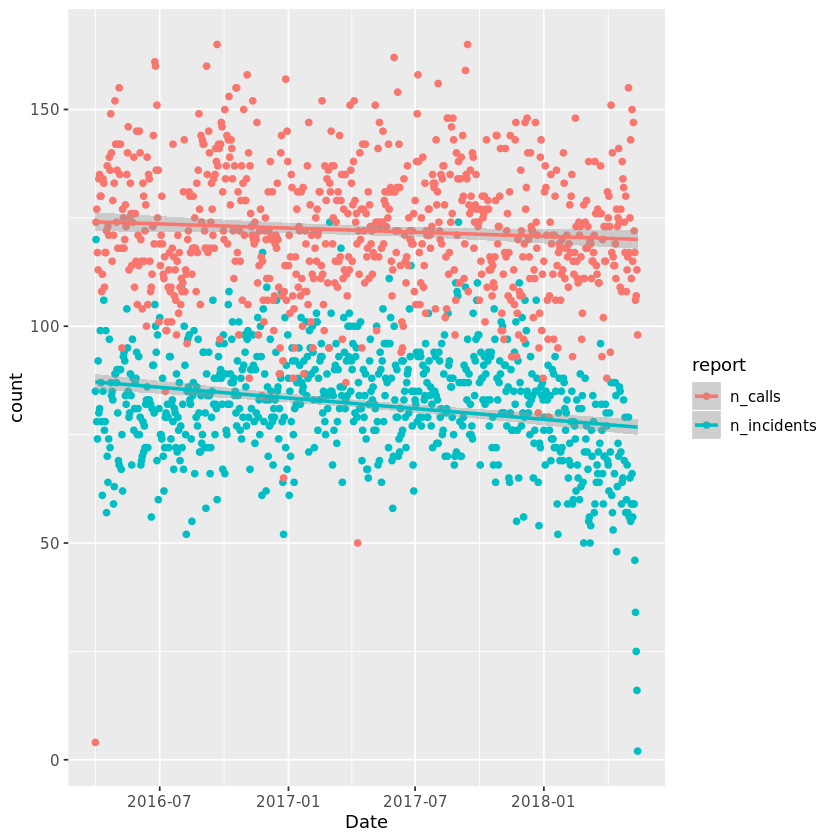

In [153]:
# Gather into long format using the "Date" column to define observations
plot_shared_dates <- shared_dates %>%
  gather(key = report, value = count, -Date)
head(plot_shared_dates)
# # Plot points and regression trend lines
ggplot(plot_shared_dates, aes(x =Date, y = count, color = report)) +
  geom_point() +
  geom_smooth(method = "lm", formula = y ~ x)

## 5. Correlation between trends
<p>A more quantitive way to discern the relationship between 2 variables is to calculate a correlation coefficient between vectors of data. This statistic is represented between a range from -1 to +1; specifically it represents the linear dependence between two sets of data. The correlation coefficient can be interpreted as perfect negative correlation when -1, no correlation whatsoever when 0, and perfect positive correlation when +1. We will look at 2 different but related correlation coefficients in order to understand how our interpretation of statistics can greatly influence the conclusions we come to.</p>
<p>We will first check if there is a correlation between the frequency of incidents and calls on a day-to-day basis. However, this may be too granular of a statistic - year over year daily correlations are probably only likely on big events (New Year's Eve, Halloween, Bay to Breakers). It may be helpful to take a broader view of inherent trends by summarising the data into monthly counts and calculating a correlation coefficient.</p>

In [155]:
# Calculate correlation coefficient between daily frequencies
daily_cor <- cor(shared_dates$n_incidents, shared_dates$n_calls)
daily_cor

# Summarize frequencies by month
correlation_df <- shared_dates %>% 
  mutate(month = month(Date)) %>%
  group_by(month) %>% 
  summarize(n_incidents = sum(n_incidents),
            n_calls = sum(n_calls))
head(correlation_df)
# Calculate correlation coefficient between monthly frequencies
monthly_cor <- cor(correlation_df$n_incidents, correlation_df$n_calls)
monthly_cor

[1] 0.1469688

`summarise()` ungrouping output (override with `.groups` argument)


month,n_incidents,n_calls
1,5078,7210
2,4484,6622
3,5042,7523
4,7104,11143
5,5944,9654
6,4917,7425


[1] 0.970683

## 6. Filtering joins
<p>When working with relational datasets there are situations in which it is helpful to subset information based on another set of values. Remember mutating joins? Filtering joins are a complementary type of join which allows us to keep all specific cases within a data frame while preserving the structure of the data frame itself. It will be helpful to have all the information from each police reported incident and each civilian call on their shared dates so we can calculate similar statistics from each dataset and compare results. In this case we will use <code>shared_dates</code> to subset down both the full <code>calls</code> and <code>incidents</code> data frames.</p>

In [157]:
# Subset calls to police by shared_dates
calls_shared_dates <- semi_join(calls, shared_dates, by = c("Date" = "Date"))
head(calls_shared_dates,2)
head(calls,2)
# Perform a sanity check that we are using this filtering join function appropriately
identical(sort(unique(shared_dates$Date)), sort(unique(calls_shared_dates$Date)))

# Filter recorded incidents by shared_dates
incidents_shared_dates <- semi_join(incidents, shared_dates, by = c("Date" = "Date"))

Crime Id,Descript,Report Date,Date,Offense Date,Call Time,Call Date Time,Disposition,Address,City,State,Agency Id,Address Type,Common Location
163003307,Bicyclist,2016-10-26,2016-10-26,2016-10-26,17:47:00,2016-10-26 17:47:00,GOA,The Embarcadero Nor/kearny St,San Francisco,CA,1,Intersection,NA
180870423,586,2018-03-28,2018-03-28,2018-03-28,05:49:00,2018-03-28 05:49:00,HAN,Ingalls St/van Dyke Av,San Francisco,CA,1,Intersection,NA


Crime Id,Descript,Report Date,Date,Offense Date,Call Time,Call Date Time,Disposition,Address,City,State,Agency Id,Address Type,Common Location
163003307,Bicyclist,2016-10-26,2016-10-26,2016-10-26,17:47:00,2016-10-26 17:47:00,GOA,The Embarcadero Nor/kearny St,San Francisco,CA,1,Intersection,NA
180870423,586,2018-03-28,2018-03-28,2018-03-28,05:49:00,2018-03-28 05:49:00,HAN,Ingalls St/van Dyke Av,San Francisco,CA,1,Intersection,NA


[1] TRUE

## 7. True crime
<p>Back to some data viz! Now we need to see what the data look like after joining the datasets. Previously we made a scatterplot and fit a linear model to the data to see if there was a trend in the frequency of calls and the frequency of reported incidents over time. Scatterplots are a great tool to look at overall trends of continuous data. However, to see trends in categorical data, we need to visualize the ranked order of the variables to understand their levels of importance.</p>

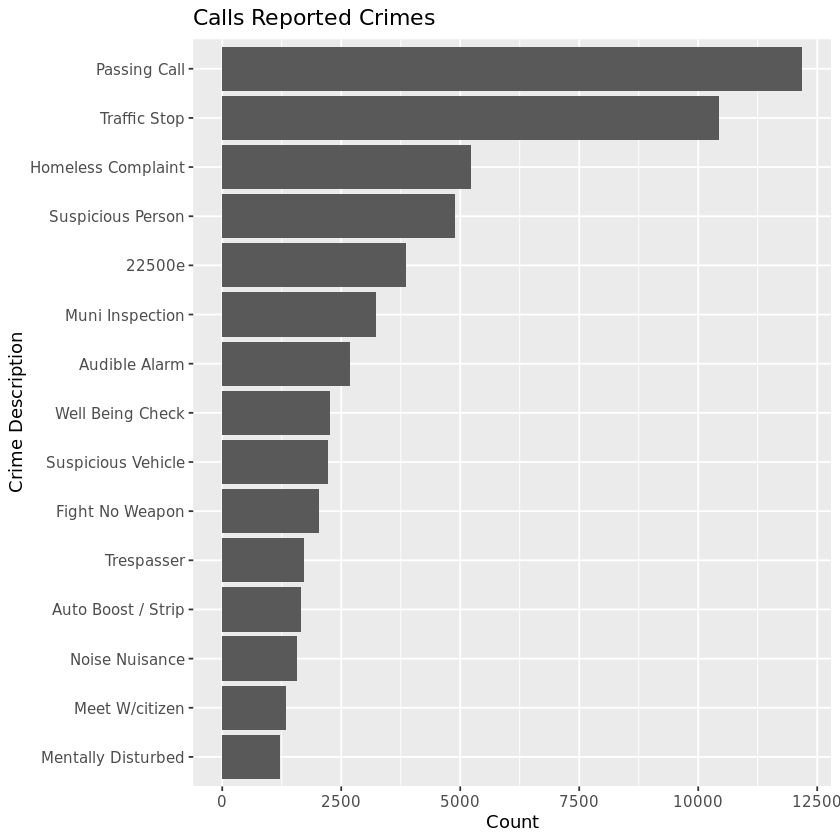

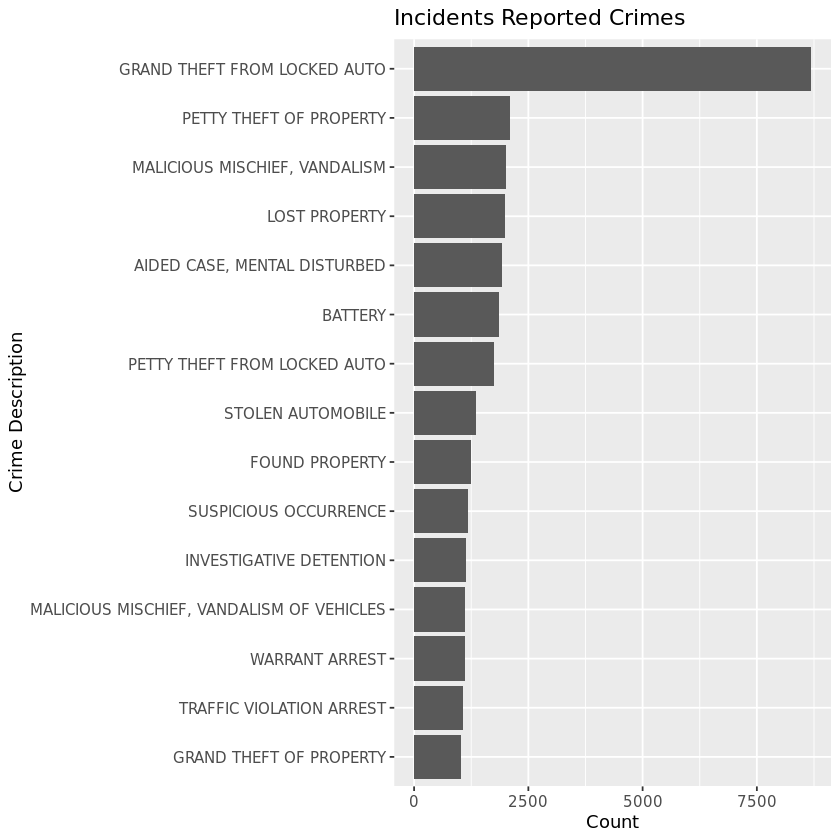

In [159]:
# Create a bar chart of the number of calls for each crime
plot_calls_freq <- calls_shared_dates %>% 
  count(Descript, sort=TRUE) %>% 
  top_n(15, n) %>% 
  ggplot(aes(x = reorder(Descript, n), y = n)) +
  geom_bar(stat = 'identity') +
  ylab("Count") +
  xlab("Crime Description") +
  ggtitle("Calls Reported Crimes") +
  coord_flip()
  

# Create a bar chart of the number of reported incidents for each crime
plot_incidents_freq <- incidents_shared_dates %>% 
  count(Descript, sort=TRUE) %>% 
  top_n(15, n)  %>% 
  ggplot(aes(x = reorder(Descript, n), y = n)) +
  geom_bar(stat = 'identity') +
  ylab("Count") +
  xlab("Crime Description") +
  ggtitle("Incidents Reported Crimes") +
  coord_flip()

# Output the plots
plot_calls_freq
plot_incidents_freq

## 8. Grand theft auto
<p>Interesting - far and away the crime of highest incidence is "GRAND THEFT FROM LOCKED AUTO". This category probably captures many crimes of opportunity where unsupervised vehicles are broken into. However, there <strong>are</strong> vigilantes out there trying to prevent crime! The 12th most civilian reported crime is "Auto Boost / Strip"! Maybe these civilians are truly helping to prevent crime. Yet, this is probably only the case where the location of a called-in-crime is similar to the location of crime incidence. Let's check to see if the locations of the most frequent civilian reported crime and police reported crime are similar.</p>

In [161]:
# Arrange the top 10 locations of called in crimes in a new variable
location_calls <- calls_shared_dates %>%
  filter(Descript == "Auto Boost / Strip") %>% 
  count(Address) %>% 
  arrange(desc(n))%>% 
  top_n(10, n)

# Arrange the top 10 locations of reported incidents in a new variable
location_incidents <- incidents_shared_dates %>%
  filter(Descript == "GRAND THEFT FROM LOCKED AUTO") %>% 
  count(Address) %>% 
  arrange(desc(n))%>% 
  top_n(10, n)

# Print the top locations of each dataset for comparison
location_calls
location_incidents

Address,n
1100 Block Of Point Lobos Av,21
3600 Block Of Lyon St,20
100 Block Of Christmas Tree Point Rd,18
1300 Block Of Webster St,12
500 Block Of 6th Av,12
800 Block Of Vallejo St,10
1000 Block Of Great Hy,9
100 Block Of Hagiwara Tea Garden Dr,7
1100 Block Of Fillmore St,7
3300 Block Of 20th Av,7


Address,n
800 Block of BRYANT ST,441
500 Block of JOHNFKENNEDY DR,89
1000 Block of POINTLOBOS AV,84
800 Block of MISSION ST,61
2600 Block of GEARY BL,38
3600 Block of LYON ST,36
1300 Block of WEBSTER ST,35
1100 Block of FILLMORE ST,34
22ND ST / ILLINOIS ST,33
400 Block of 6TH AV,30


## 9. Density map
<p>It appears the datasets share locations where auto crimes occur and are reported most frequently - such as on Point Lobos Avenue, Lyon Street, and Mission Street. It would be great to plot co-occurrence of these locations to visualize overlap, however we only have longitude and latitude data for police reported <code>incidents</code>. No matter, it will still be very valuable to inspect the frequency of auto crime occurrence on a map of San Francisco. This will give us immediate insight as to where auto crimes occur. Most importantly, this visualization will provide a powerful means of communication.</p>
<p>As we ask deeper questions it becomes obvious that many details of each dataset are not standardized (such as the <code>Address</code> variable in each data frame and the lack of exact location data in <code>calls</code>) and thus require more advanced analysis. Now this is the fun part - applying your technical creativity to difficult questions. Go forth from here, check out the <a href="https://www.kaggle.com/san-francisco/sf-police-calls-for-service-and-incidents">original dataset</a>, and ask some new questions!</p>

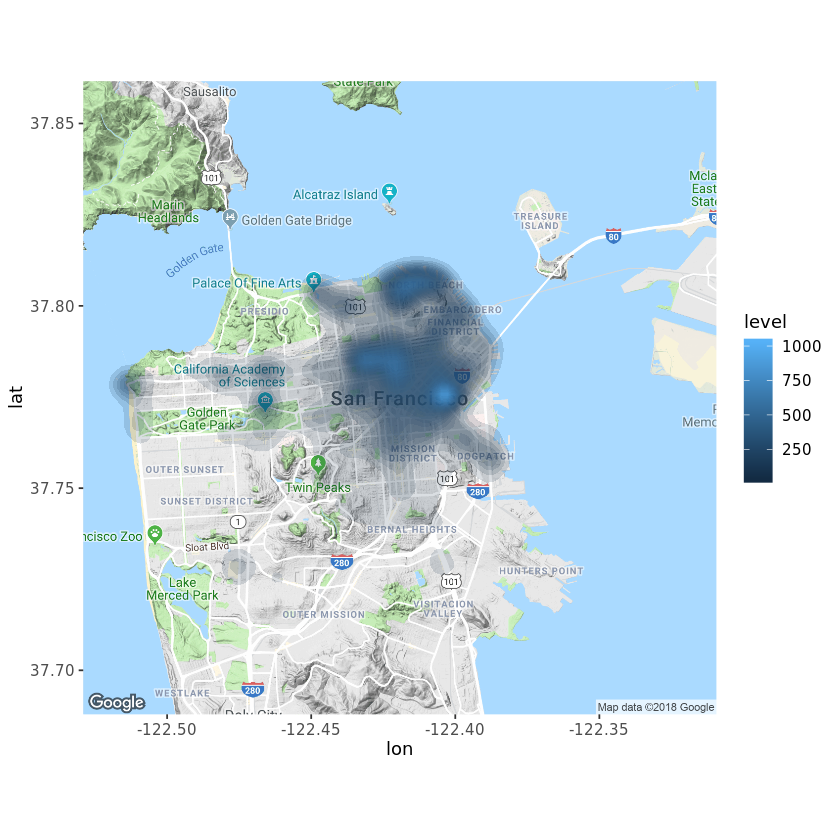

In [165]:
# Load ggmap
library(ggmap)
# Read in a static map of San Francisco 
sf_map <- readRDS("datasets/sf_map.RDS")

# Filter grand theft auto incidents
auto_incidents <- incidents_shared_dates %>%
  filter(Descript == "GRAND THEFT FROM LOCKED AUTO")

# Overlay a density plot of auto incidents on the map
ggmap(sf_map) +
  stat_density_2d(
    aes(x = X, y = Y, fill = ..level..), alpha = 0.15,
    size = 0.01, bins = 30, data = auto_incidents,
    geom = "polygon")